In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import sklearn
import re


sns.set(rc={'figure.figsize':(16,10)})
device = 'cpu'

# Анализ датасета
Подгрузим данные и посчитаем долю классов.

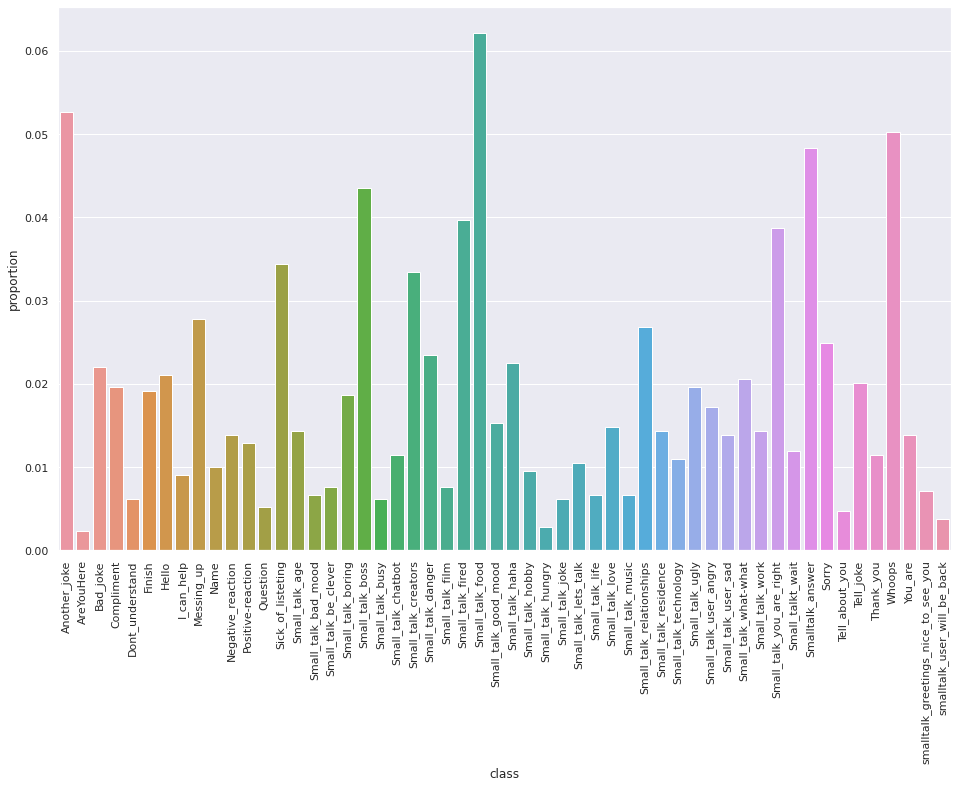

In [2]:
data = pd.read_csv('dataset_intent_detection.csv', names= ['label', 'text'])

total_number_of_cases = data.shape[0]

classes, counts = np.unique(data['label'], return_counts=True)
proportions = counts / total_number_of_cases

classes_proportions = pd.DataFrame({'class': classes, 'proportion': proportions})


def draw_classes_count(classes, counts):
    sns.barplot(x=classes, y=counts)
    plt.xticks(rotation=90)
    plt.show()
    
    
draw_classes_count(classes_proportions['class'], classes_proportions['proportion'])

В целом классы несбалансированы. Нужно будет учесть это при обучении.

Разделим выборку на train и test части. Отложим 20% данных на тест.

In [3]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(data['text'].to_numpy(), data['label'].to_numpy(), test_size=0.2,
                                                                      shuffle=True, stratify=data['label'], random_state=0)

На всякий случай проверим, что и в train и в test попали все классы

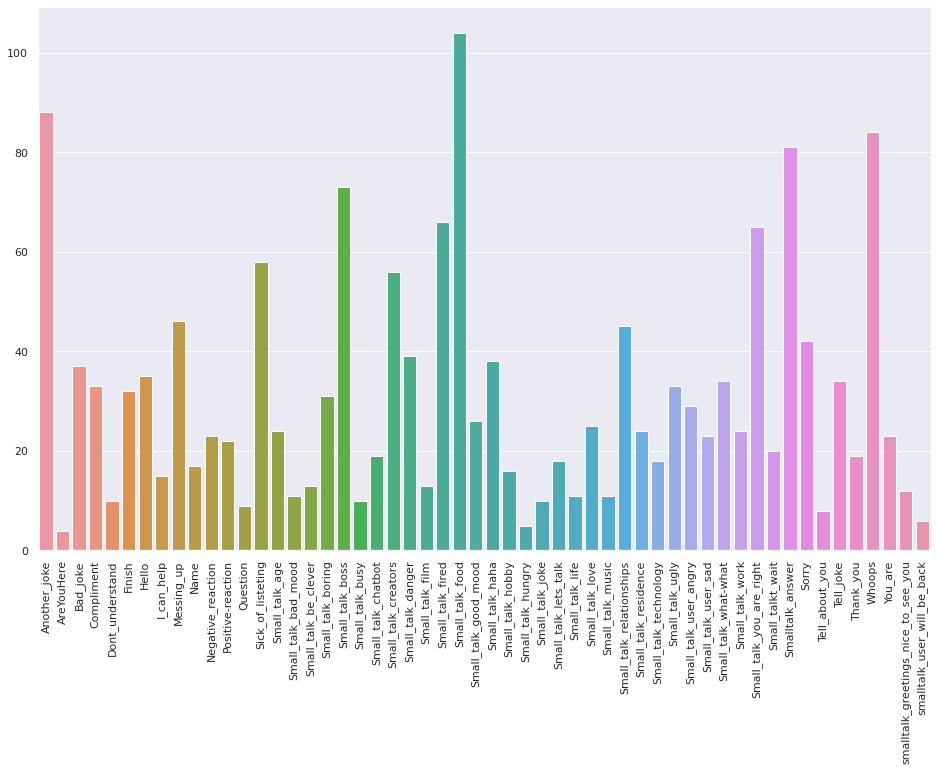

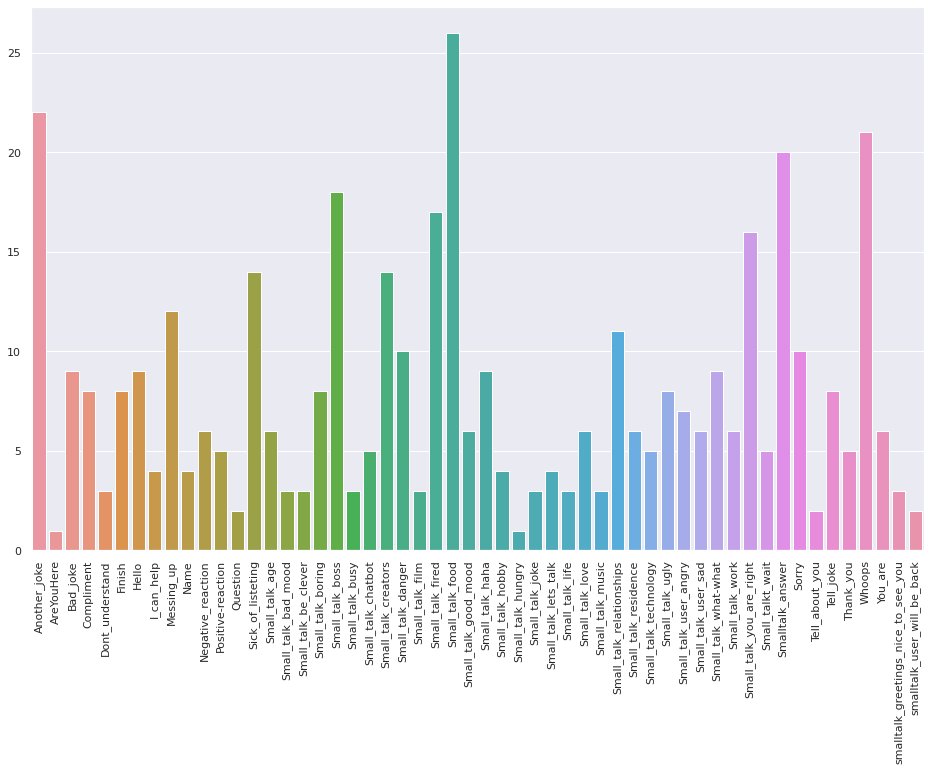

In [4]:
draw_classes_count(*(np.unique(train_labels, return_counts=True)))

draw_classes_count(*(np.unique(test_labels, return_counts=True)))

Действительно, все классы присутствуют в обоих выборках.

<!-- Далее работаем только с train выборкой, чтобы избежать искажений, вызванных использованием тестовых данных при выборе модели. -->

Посчитаем разбиение слов по классам. <!-- Будем далее использовать подход Bag Of Words. Не забудем удалить "мусорные слова" (вида "Я", "что", "но" и.т.д.) А также привести слова к начальной форме. -->

In [5]:
# # Thanks to Alexander Mamayev for this easy russian language preprocessing :
# # https://www.kaggle.com/code/alxmamaev/how-to-easy-preprocess-russian-text/script
# import nltk
# nltk.download("stopwords")

# from nltk.corpus import stopwords
# from pymystem3 import Mystem
# from string import punctuation

# mystem = Mystem() 
# russian_stopwords = stopwords.words("russian")


# def preprocess_text(text):
#     """ Performs preprocessing, returns a bag of words convertert to their first form, with stopwords removed """
#     tokens = mystem.lemmatize(text.lower())
#     tokens = [token for token in tokens if token not in russian_stopwords\
#               and token != " " \
#               and token.strip() not in punctuation]
    
#     text = " ".join(tokens)
    
#     return text


# Do not forget to clear the loaction of mystem installation and nltk installation after usage
# Have not found a way for them to use a custom directory yet

In [6]:
# bags_of_words = {label: [] for label in classes}
# for i in range(len(train_labels)):
#     bags_of_words[train_labels[i]] += preprocess_text(train_texts[i]).split()

bags_of_words = {label: [] for label in classes}
for i in range(len(train_labels)):
    bags_of_words[train_labels[i]] += re.sub("[^\w]", " ", train_texts[i]).split()

    

{label: np.array(np.unique(bags_of_words[label], return_counts=True)).T for label in bags_of_words}['Another_joke']
# {label: len(np.unique(bags_of_words[label])) for label in bags_of_words}

array([['Бот', '1'],
       ['Вы', '1'],
       ['Да', '1'],
       ['Есть', '1'],
       ['Еще', '1'],
       ['Ещё', '1'],
       ['Знаете', '5'],
       ['Знаешь', '1'],
       ['Как', '3'],
       ['Какие', '7'],
       ['Какую', '1'],
       ['Мне', '1'],
       ['Можешь', '3'],
       ['Поделитесь', '1'],
       ['Пожалуйста', '1'],
       ['Почему', '1'],
       ['Разве', '1'],
       ['Расскажешь', '1'],
       ['Расскажи', '2'],
       ['Расскажите', '6'],
       ['Скажи', '1'],
       ['Скажите', '2'],
       ['Ты', '1'],
       ['У', '5'],
       ['Хочешь', '2'],
       ['Что', '2'],
       ['Шутка', '1'],
       ['Я', '4'],
       ['а', '1'],
       ['анекдот', '1'],
       ['арсенал', '2'],
       ['более', '2'],
       ['бы', '2'],
       ['в', '1'],
       ['вас', '1'],
       ['вторая', '1'],
       ['второй', '1'],
       ['вторую', '2'],
       ['вы', '5'],
       ['говорил', '1'],
       ['гони', '1'],
       ['грязную', '1'],
       ['давай', '2'],
       ['другая',

Видно,что для некоторых классов (как, например, для 'Another_joke') есть характерные часто встречающиеся слова. Возможно, это можно будет использовать при выборе используемой модели.

# Построение модели
## Для начала соберём baseline

Используем предобученный эмбеддинг из библиотеки fasttext

In [7]:
import fasttext
import fasttext.util
import re
ft = fasttext.load_model('/mnt/HDD/cc.ru.300.bin')

In [8]:
def split_and_embed(string):
    return torch.tensor([ft.get_word_vector(word) for word in re.sub("[^\w]", " ",  string).split()], device=device)


labels_to_int = {label: index for index, label in enumerate(classes)}

In [9]:
# Transform data to format, which works with pytorch 
def create_dataset(texts, labels):
    return [(split_and_embed(texts[i]),
            torch.tensor(labels_to_int[labels[i]], dtype=torch.long, device=device)) 
           for i in range(len(labels))]
train_dataset = create_dataset(train_texts, train_labels)
test_dataset = create_dataset(test_texts, test_labels)

/tmp/ipykernel_502354/1538188690.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  return torch.tensor([ft.get_word_vector(word) for word in re.sub("[^\w]", " ",  string).split()], device=device)


В качестве модели будем обучать рекуррентную сеть LSTM

In [10]:
class classifier(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device
    
    
    def __init__(self, output_dim, emb_dim = 300, hidden_dim = 100, 
                 num_layers = 3, bidirectional = False, p=0.7, hidden_linear_dim=40, linear_layers_num=1):
        # TODO сделать больше чем 1 линейный слой после LSTM?
        super(classifier, self).__init__()
        self.encoder = torch.nn.LSTM(emb_dim, hidden_dim, num_layers, 
                                     bidirectional=bidirectional, 
                                     batch_first=False, dropout=p)
        self.linear = torch.nn.Linear(
            2*num_layers*int(bidirectional + 1)*hidden_dim, 
            output_dim)
        self.linear
        
        
    def forward(self, input):
        _, (h, c) = self.encoder(input)
        act = torch.cat([h, c], dim=0).transpose(0, 1)
        act = act.flatten()
        return self.linear(act)

emb_dim = 300
hidden_dim = 100
num_layers = 3
p=0.7    

model = classifier(output_dim=len(classes), emb_dim=emb_dim, hidden_dim=hidden_dim, num_layers=num_layers, p=p)

Код для обучения:

In [11]:
def trainer(count_of_epoch,  
            dataset,
            model, 
            loss_function,
            optimizer,
            writer,
            lr = 0.001):
    def make_val_report(iteration):
        # Будь у нас больше данных, здесь использовались бы данные для валидации (а не прямо тестовые),
        # но так как некоторых классов размечено буквально 5 примеров, мы этого делать не будем.
        # TODO отобрать датасет для валидации   
        report = calculate_test_performance(model, test_dataset)
        def report_avg(which_avg):
            for metric in report[which_avg]:
                if metric != 'support':
                    writer.add_scalar(f'metrics/{which_avg}/{metric}', report[which_avg][metric], iteration)
        report_avg('weighted avg')
        report_avg('macro avg')
        writer.add_scalar(f'metrics/accuracy', report['accuracy'], iteration)
        
    
    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:        
        epoch_loss = train_epoch(train_generator=dataset, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})
        writer.add_scalar('metrics/train_loss', epoch_loss, it)
        make_val_report(it)    
        

def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    
    epoch_loss = 0
    total = 0
    for x, y in train_generator:
        optimizer.zero_grad()

        output = model(x.to(model.device))

        loss = loss_function(output, y.to(model.device))
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.cpu().item()
        total += 1
    
    return epoch_loss/total


def calculate_test_performance(model, test_dataset):
    model.eval()
    
    y_pred = [torch.argmax(model(x.to(model.device))) for x, y in test_dataset]
    y_target = [y for x, y in test_dataset]
    
    return sklearn.metrics.classification_report(y_target, y_pred, output_dict=True,zero_division=0)
    

Проведём оптимизацию гиперпараметров

In [12]:
already_calculated = set()
# already_calculated
# already_calculated.remove('emb_dim=300,hidden_dim=10,num_layers=3,p=0.4')

In [13]:
# emb_dim = 300
# hidden_dim = 100
# num_layers = 3
# p=0.4

# # for p in [0, 0.2, 0.4, 0.6, 0.8]:
# # for hidden_dim in [10, 50, 100, 200]:
# # for num_layers in [1,2,3,5,7]:
# title = f'emb_dim={emb_dim},hidden_dim={hidden_dim},num_layers={num_layers},p={p}'
# if not title in already_calculated:
#     print(title)
#     model = classifier(output_dim=len(classes), emb_dim=emb_dim, hidden_dim=hidden_dim, num_layers=num_layers, p=p)

#     loss = torch.nn.CrossEntropyLoss()
#     writer = SummaryWriter(log_dir = f'/local/tmp/tmp/{title}')
#     trainer(20, train_dataset, model, loss, torch.optim.Adam, writer)
#     already_calculated.add(title)


Заглянем в графики tensorboard'а:

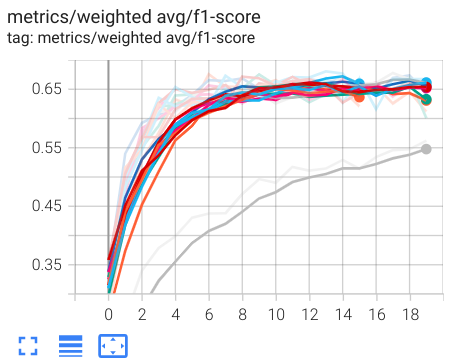

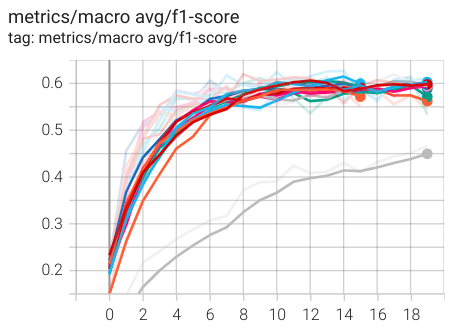

Видно, что (почти)независимо от гиперпараметров модель сходится к (macro average f1 = 0.6; weighted average f1 =0.65)